In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from pandas_datareader import data as pdr
import yfinance as yf
yf.pdr_override()

import warnings
warnings.filterwarnings("ignore")

In [2]:
spy = pdr.get_data_yahoo("SPY", "2004-11-01", "2023-11-01")

[*********************100%%**********************]  1 of 1 completed


In [3]:
aapl = pdr.get_data_yahoo("aapl", "2004-11-01", "2023-11-01")

[*********************100%%**********************]  1 of 1 completed


In [4]:
msft = pdr.get_data_yahoo("msft", "2004-11-01", "2023-11-01")

[*********************100%%**********************]  1 of 1 completed


# 1.Baseline

In [5]:
#here we only need stock with columns call"Adj Close"and "position" then we can calculate its strategy culmulative return
def cal_str_cul_return(stock1):
    stock = stock1.copy()
    
    stock["daily_return"] = stock["Adj Close"].pct_change()
    
    stock["str_return"] = stock["position"].shift(1)*stock["daily_return"]
    stock["cul_return"] = (1+stock["str_return"]).cumprod()
    return stock

In [6]:
#first we calculate baseline performance
spy1 = spy[["Adj Close"]]

spy1["position"] = 1

spy1 = cal_str_cul_return(spy1)

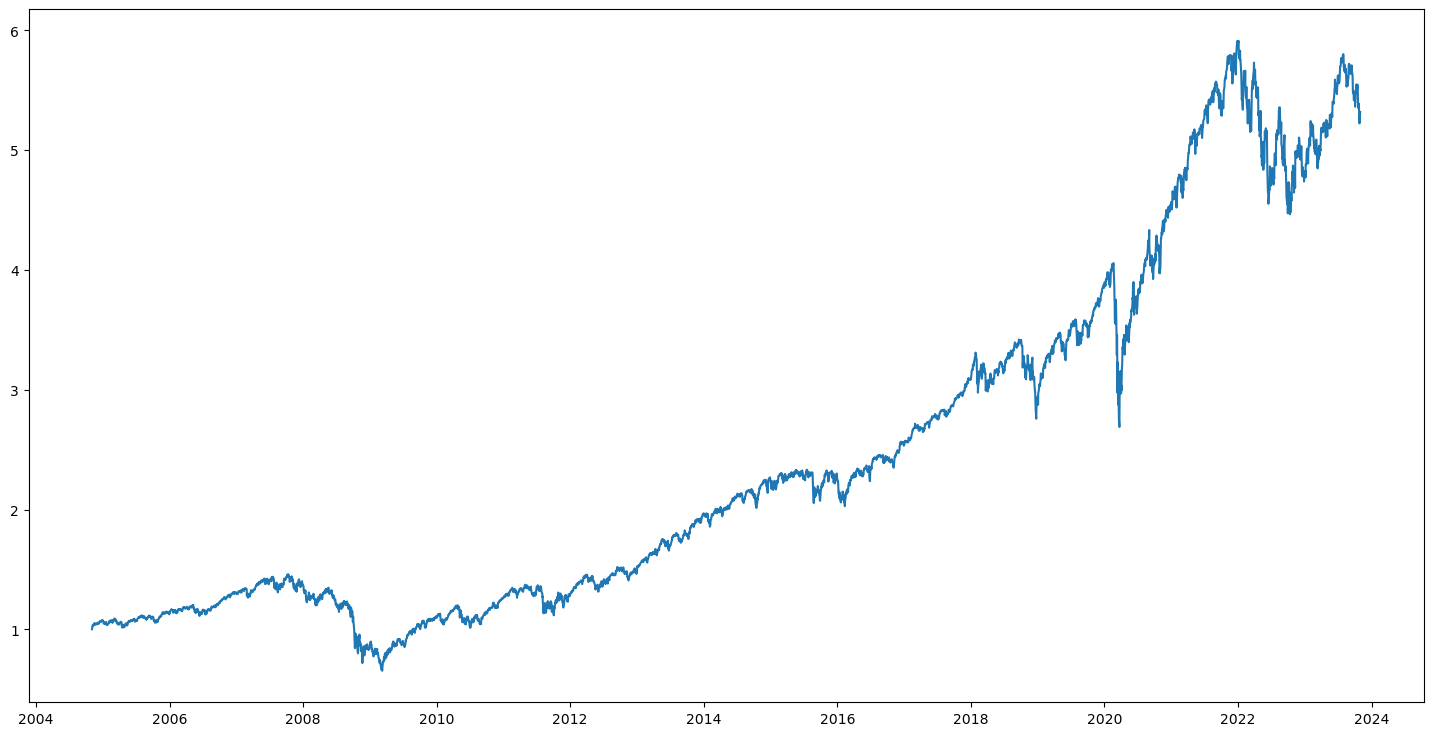

In [7]:
plt.figure(figsize=[18,9])
plt.plot(spy1["cul_return"])
plt.show()

In [8]:
#df column calld "str_return"
def cal_sharpe(stock):
    Sharpe =\
    (
        np.sqrt(253) * (stock["str_return"].mean() / stock["str_return"].std()
                        )
    )

    return Sharpe

In [9]:
#df with colum called "cul_return", index date
def cal_CAGR(stock):
    days =\
    (    (stock.index[-1] - stock.index[0])
         .days
    )

    CAGR =\
    (
        (
          (
            (stock["cul_return"][-1]) / 1
          )
            **(365.0/days) 
        ) 
        - 1
    )

    return CAGR

In [10]:
def cal_max_drawdown(stock1):
    stock = stock1.copy()
    
    stock["max_performance"] = stock["cul_return"].cummax()
    stock["drawdown"] = 1 - stock["cul_return"]/stock["max_performance"]
    max_drawdown = stock["drawdown"].max()
    return max_drawdown

In [11]:
def cal_metrics(stock):
    return pd.Series({"sharpe_ratio": cal_sharpe(stock), "CAGR": cal_CAGR(stock), "max_drawdown":cal_max_drawdown(stock)})

In [12]:
cal_metrics(spy1)

sharpe_ratio    0.554122
CAGR            0.091910
max_drawdown    0.551894
dtype: float64

# 2.strategy

## 2.1.RSI

In [13]:
#stock here must be a df with one column called "Adj Close"
def cal_RSI(stock1):
    stock = stock1.copy()
    period = 14

    stock["change"] = stock["Adj Close"].diff()

    stock["gain"] = stock["change"].apply(lambda x: x if x > 0 else 0)
    stock["loss"] = stock["change"].apply(lambda x: -x if x < 0 else 0)

    stock["avg_gain"] = stock["gain"].rolling(period).mean()
    stock["avg_loss"] = stock["loss"].rolling(period).mean()

    for i in range(14,len(stock)):
        stock.iloc[i,4] = (stock.iloc[i-1]["avg_gain"]*13+stock.iloc[i]["gain"])/14
        stock.iloc[i,5] = (stock.iloc[i-1]["avg_loss"]*13+stock.iloc[i]["loss"])/14

    stock["RS"] = stock["avg_gain"]/stock["avg_loss"]
    stock["RSI"] = 100 - 100/(1+stock["RS"])
    
    return stock["RSI"]

In [14]:
#here stock need to be a df with one column named "RSI"
def set_RSI_position(stock1):
    stock = stock1.copy()
    #set RSI_position
    stock["RSI"] = cal_RSI(stock)

    stock["RSI_position"] = np.where(((stock["RSI"]-70)*(stock["RSI"].shift(1)-70)<0)&(stock["RSI"]<70), -1, np.nan)

    #alorithm impovement seems not to imporve....
#     stock["RSI_position"] = np.where(((stock["RSI"]-70)*(stock["RSI"].shift(1)-70)<0)&(stock["RSI"]>70), 0, stock["RSI_position"])
#     stock["RSI_position"] = np.where(((stock["RSI"]-30)*(stock["RSI"].shift(1)-30)<0)&(stock["RSI"]<30), 0, stock["RSI_position"])

    stock["RSI_position"] = np.where(((stock["RSI"]-30)*(stock["RSI"].shift(1)-30)<0)&(stock["RSI"]>30), 1, stock["RSI_position"])
    stock["RSI_position"] = np.where(((stock["RSI"]-50)*(stock["RSI"].shift(1)-50)<0), 0, stock["RSI_position"])
    stock["RSI_position"] = stock["RSI_position"].ffill()
    stock["RSI_position"] = stock["RSI_position"].fillna(0)

    #we need to shift our RSI_position downward cuz we open RSI_position in close price
    stock["RSI_position"] = stock["RSI_position"].shift(1)
    stock["RSI_position"] = stock["RSI_position"].fillna(0)
    return stock["RSI_position"]

## 2.2.MACD

In [15]:
#here we need stock with column with "Adj Close"
def set_MACD_position(stock1, short, long, signal):
    stock = stock1.copy()
    #short and long EWM
#     short_EWM = 12
#     long_EWM = 26
    short_EWM = short
    long_EWM = long

    stock["short_EWM"] = stock["Adj Close"].ewm(span=short_EWM).mean()
    stock["long_EWM"] = stock["Adj Close"].ewm(span=long_EWM).mean()

    #MACD and MACD signal line
    #signal = 9

    stock["MACD"] = stock["short_EWM"] - stock["long_EWM"]
    stock["MACD_signal"] = stock["MACD"].ewm(span = signal).mean()

    stock["MACD_position"] = np.where(stock["MACD"] > stock["MACD_signal"], 1, -1)
    return stock["MACD_position"]

## 2.3.Bollinger Bands

In [16]:
#as a assist signal
def set_BB_position(stock1, period, multiplier):
    stock = stock1.copy()
    
    stock[f"SMA_{period}"] = stock["Adj Close"].rolling(period).mean()
    stock["upper_threshold"] = multiplier*stock["Adj Close"].rolling(period).std() + stock[f"SMA_{period}"]
    stock["lower_threshold"] = -multiplier*stock["Adj Close"].rolling(period).std() + stock[f"SMA_{period}"]

    distance = stock["Adj Close"] - stock[f"SMA_{period}"]
    stock["BB_position"] = np.where(stock["Adj Close"] > stock["upper_threshold"], -1, np.nan)
    stock["BB_position"] = np.where(stock["Adj Close"] < stock["lower_threshold"], 1, stock["BB_position"])
    stock["BB_position"].ffill(inplace = True)
    stock["BB_position"] = stock["BB_position"].fillna(0)
    
    return stock["BB_position"]

## 2.4. Simple Momentum

### 2.4.1.Simple Momentum

In [17]:
def set_SM_position(stock1, short, long):
    stock = stock1.copy()
    
#     short = 20
#     long = 60

    stock["long_SMA"] = stock["Adj Close"].rolling(long).mean()
    stock["short_SMA"] = stock["Adj Close"].rolling(short).mean()


    stock["SM_position"] = np.where(stock["short_SMA"]>stock["long_SMA"], 1, -1)
    stock["SM_position"][:long] = 0
    return stock["SM_position"]

### 2.4.2 Long Only Simple Momentum

In [18]:
def set_SML_position(stock1, short, long):
    stock = stock1.copy()
    
#     short = 20
#     long = 60

    stock["long_SMA"] = stock["Adj Close"].rolling(long).mean()
    stock["short_SMA"] = stock["Adj Close"].rolling(short).mean()


    stock["SM_position"] = np.where(stock["short_SMA"]>stock["long_SMA"], 1, 0)
    stock["SM_position"][:long] = 0
    return stock["SM_position"]

## 2.5.Stochastic Oscillator

In [87]:
def set_SO_position(stock1, period_K, period_D):
    stock = stock1.copy()

    stock["min"] = stock["Adj Close"].rolling(period_K).min()
    stock["max"] = stock["Adj Close"].rolling(period_K).max()
    percentage_K = 100*(stock["Adj Close"] - stock["min"])/(stock["max"]-stock["min"])
    percentage_D = percentage_K.rolling(period_D).mean()
    
    stock["SO_position"] = np.where(percentage_K>percentage_D, 1, -1)
    stock["SO_position"] = stock["SO_position"].fillna(0)
    return stock["SO_position"]

## 2.6.Commodity Channel Index

In [20]:
# period = 20
# constant = 0.015
#stock data with columns with "High", " Low" ,"Close"
def set_CCI_position(stock1, period, constant):
    stock = stock1.copy()
    
    stock["typical_price"] = (stock["High"] + stock["Low"] + stock["Close"])/3
    stock["SMA"] = stock["Close"].rolling(period).mean()
    stock["typical_price_std"] = stock["typical_price"].rolling(period).std()

    CCI = (stock["typical_price"] - stock["SMA"])/(constant*stock["typical_price_std"])
    stock["CCI_position"] = np.where(CCI > 100, -1, np.nan)
    stock["CCI_position"] = np.where(CCI < -100, 1, stock["CCI_position"])
    
    stock["CCI_position"].ffill(inplace = True)
    stock["CCI_position"] = stock["CCI_position"].fillna(0)
    return stock["CCI_position"]

## 2.7.Momentum Indicator Crossover Strategy

In [74]:
def set_MICS_position(stock1, period, buy_threshold, sell_threshold):
    stock = stock1.copy()
    
    spy2['momentum'] = spy2['Adj Close'].diff(period)
    spy2["MICS_position"] = np.where(spy2["momentum"]> buy_threshold, 1, -1)
    return spy2["MICS_position"]

# 3. Combined Strategy

## 3.1. Bollinger Bands&MACD

### 3.1.1. SPY

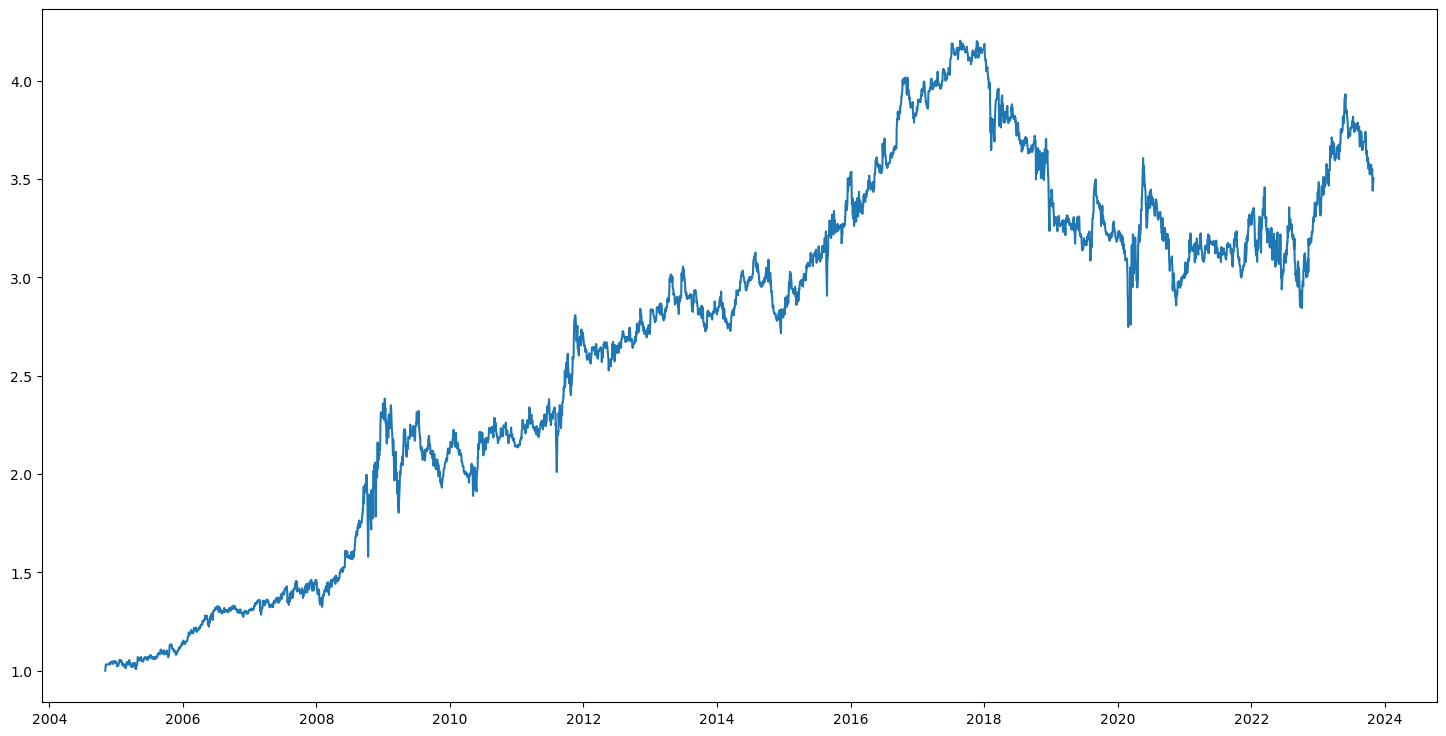

In [81]:
spy2 = spy[["High", "Low", "Close","Adj Close"]]


#spy2["RSI_position"] = set_RSI_position(spy2)
# spy2["CCI_position"] = set_CCI_position(spy2, 20, 0.015)
# spy2["BB_position"] = set_BB_position(spy2, 20,2)
spy2["SO_position"] = set_SO_position(spy2, 14)
# spy2["MACD_position"] = set_MACD_position(spy2, 10, 26, 9)
# spy2["SM_position"] = set_SM_position(spy2, 20, 60)
spy2["MICS_position"] = set_MICS_position(spy2,5,0,0)
# spy2["SML_position"] = set_SML_position(spy2, 20, 60)

spy2["position"] = -np.where((spy2["MICS_position"])==(spy2["SO_position"]), spy2["MICS_position"], 0)
spy2 = cal_str_cul_return(spy2)
plt.figure(figsize=[18,9])
#plt.plot(spy1["cul_return"])
plt.plot(spy2["cul_return"])
plt.show()

# 4.Parameter Tuning

In [88]:
def SO_MICS_cul_return(stock1, SO_period_K, SO_period_D, MICS_period, MICS_buy, MICS_sell):
    stock = stock1.copy()
    stock = stock[["Adj Close"]]

    stock["SO_position"] = set_SO_position(stock, SO_period_K, SO_period_D)
    stock["MICS_position"] = set_MICS_position(stock, MICS_period, MICS_buy, MICS_sell)

    stock["position"] = -np.where((stock["SO_position"])==(stock["MICS_position"]), stock["SO_position"], 0)
    stock = cal_str_cul_return(stock)
    final_result = stock["cul_return"][-1]
    return final_result

In [99]:
def SO_MICS_tuning(stock1, SO_periods_K, SO_periods_D, MICS_periods, MICS_buys, MICS_sells):
    stock = stock1.copy()
    best_res = 0
    best_parameters = (0,0,0,0)
    
    for SO_period_K in SO_periods_K:
        for SO_period_D in SO_periods_D:
            for MICS_period in MICS_periods:
                for MICS_buy in MICS_buys:
                    for MICS_sell in MICS_sells:
                        parameters = (SO_period_K, SO_period_D, MICS_period, MICS_buy, MICS_sell)
                        res = SO_MICS_cul_return(stock, SO_period_K, SO_period_D, MICS_period, MICS_buy, MICS_sell)
                        if(res > best_res):
                            best_res = res
                            best_parameters = parameters
    return best_res, best_parameters

In [103]:
SO_periods_K = range(10,16)
SO_periods_D = range(3,7)
MICS_periods = range(5,20,5)
MICS_buys = np.arange(0,0.1, 0.005)
MICS_sells = np.arange(-0.1, 0, 0.005)

SO_MICS_tuning(spy2, SO_periods_K, SO_periods_D, MICS_periods, MICS_buys, MICS_sells)

(6.279921145866075, (10, 6, 5, 0.06, -0.1))

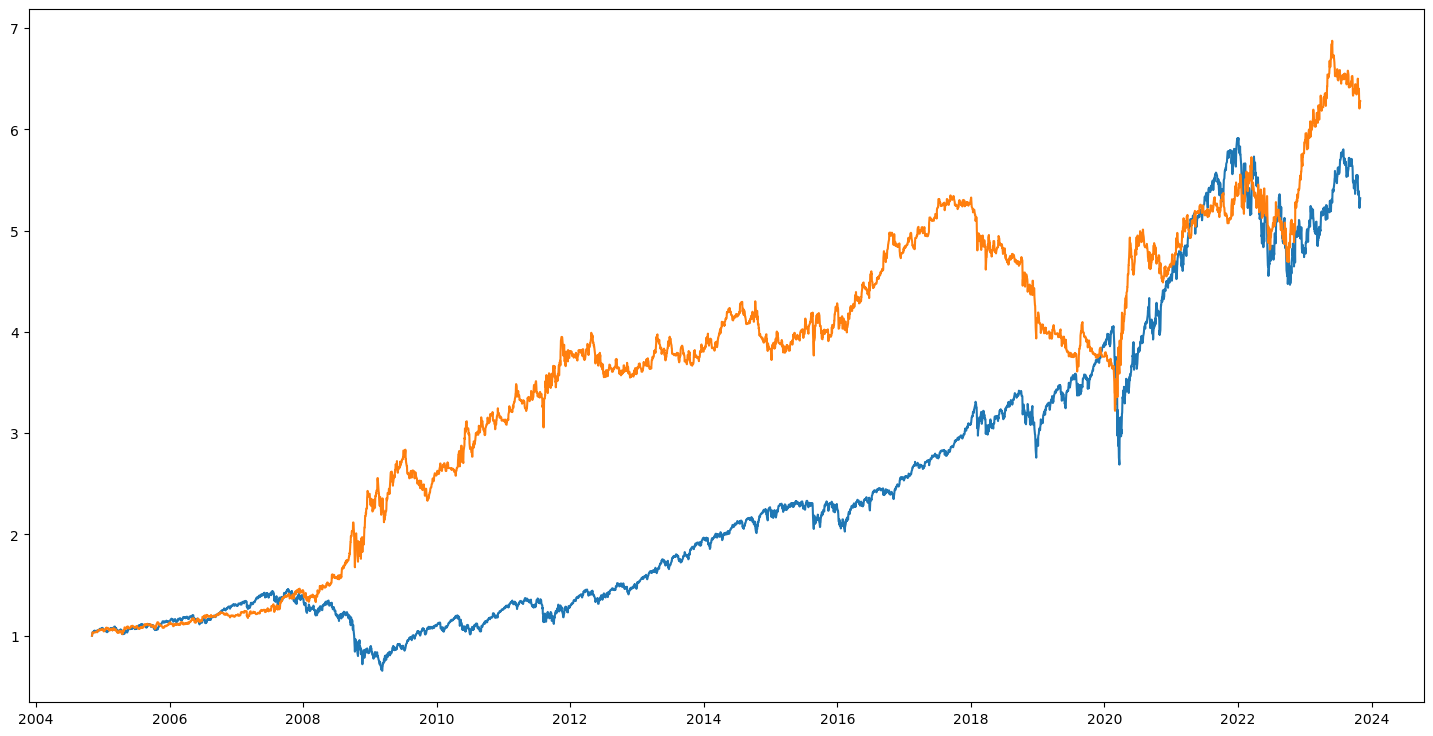

In [109]:
spy3 = spy[["Adj Close"]]



spy3["SO_position"] = set_SO_position(spy3, 10, 6)

spy3["MICS_position"] = set_MICS_position(spy3,5,0.06,-0.1)

spy3["position"] = -np.where((spy3["MICS_position"])==(spy3["SO_position"]), spy3["MICS_position"], 0)
spy3 = cal_str_cul_return(spy3)
plt.figure(figsize=[18,9])
plt.plot(spy1["cul_return"])
plt.plot(spy3["cul_return"])
plt.show()

In [110]:
cal_metrics(spy3)

sharpe_ratio    0.672884
CAGR            0.101487
max_drawdown    0.397737
dtype: float64